# GradCAM
The Grad-CAM algorithm provides a way to identify what parts of an image contribute most to the output of a classifier deep network.

In [1]:
import os, json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from IPython.display import Image, display



## Definitions

In [2]:
v_num_of_classes=30 #not needed
v_input_shape=(224, 224, 3)
v_path_dataset='../data/sampledataset'
v_image_size=(224,224)
v_color_mode="rgb" # "rgb", "rgba", or "grayscale"
v_batch_size=16 
v_epochs = 10

v_metrics=['MeanSquaredError','AUC','Precision','Recall','accuracy']
v_workspace='./exp'


## Functions

In [3]:
def load_JSON_file( path_to_file):
    try:
        obj = open(path_to_file)
        data = json.load(obj)        
        obj.close()
        retObj=json.loads(json.dumps(data))
    except Exception as e:
        retObj=e
    return retObj

def gen_file_name(filename):
    newfilename=filename
    s=newfilename.rfind('.')
    e=len(newfilename)
    sub=newfilename[s : e]    
    newfilename=newfilename.replace(sub,'_gradcam'+sub)
    return newfilename

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.4):
    

    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))
    img=mpimg.imread(cam_path)
    plt.imshow(img)
    plt.show()

## model

In [4]:
fname = os.path.join (v_workspace,"saved_model")
savedModel = os.path.join(v_workspace, "saved_model")
savedWeights = os.path.join(v_workspace,"saved_weights","weights")

model= keras.models.load_model(savedModel)
last_conv_layer_name = "Conv_1"
# model.summary()

2022-09-27 00:17:39.616758: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Input with Processing 

In [20]:


picturefile="sample_img/sunflower1.jpg"
gradcamfile=gen_file_name(picturefile)

    
img=mpimg.imread(picturefile)
img_obj = image.load_img(picturefile, target_size=v_image_size)  

# step: preprocess
   
img_array = image.img_to_array(img_obj)
img_batch = np.expand_dims(img_array, axis=0)  


img_processed=keras.applications.mobilenet_v2.preprocess_input(img_batch)

## Predict

In [21]:
preds = model.predict(img_processed)
predictions=np.argmax(preds,axis=1)

fname_indices = os.path.join (v_workspace,"class_indices.json")
class_indices=load_JSON_file(fname_indices)
print('Prediction:', class_indices[str(predictions[0])])

Prediction: sunflower


## GradCAM

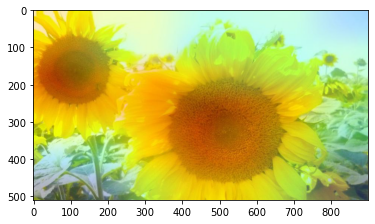

In [22]:

heatmap = make_gradcam_heatmap(img_processed, model, last_conv_layer_name)
save_and_display_gradcam(img_path= picturefile, heatmap= heatmap,cam_path= cam_path)

In [18]:
#model.summary()